In [2]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn.functional as F
import torch.nn as nn
from torch.autograd import Variable

import tqdm
import os
import mcbe
from mpl_toolkits.mplot3d import Axes3D
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import keras.datasets

In [3]:
(X_train, y_train), (X_test, y_test) = keras.datasets.mnist.load_data()

In [4]:
X_train = np.array([X_train[i].flatten() for i in range(X_train.shape[0])])
X_test = np.array([X_test[i].flatten() for i in range(X_test.shape[0])])

In [5]:
#normalize data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [6]:
# size of the layers
l1 = 1024
l2 = 128


In [7]:
class Model(nn.Module):
    def __init__(self, input_dim, l1):
        super(Model, self).__init__()
        self.layer1 = nn.Linear(input_dim, l1)
        self.layer2 = nn.Linear(l1, l2)
        self.layer3 = nn.Linear(l2, 10)
        
    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        x = F.softmax(self.layer3(x), dim=1)
        return x

In [8]:
model     = Model(X_train.shape[1],l1)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
loss_fn   = nn.CrossEntropyLoss()
model

Model(
  (layer1): Linear(in_features=784, out_features=1024, bias=True)
  (layer2): Linear(in_features=1024, out_features=128, bias=True)
  (layer3): Linear(in_features=128, out_features=10, bias=True)
)

In [9]:

X_train = Variable(torch.from_numpy(X_train)).float()
y_train = Variable(torch.from_numpy(y_train)).long()
X_test  = Variable(torch.from_numpy(X_test)).float()
y_test  = Variable(torch.from_numpy(y_test)).long()

In [18]:
#initialize lists

EPOCHS  = 50

weights = []
weights_norm = []
norms = []
biases = np.zeros([EPOCHS + 1,l1])
percent_inj_list = []

w1 = model.layer1.weight
b1 = model.layer1.bias
m1 = w1.shape[0]
n1 = w1.shape[1]
norm = w1.pow(2).sum(keepdim=True,dim=1).sqrt()
w1_norm = torch.div(w1,norm)
w1_norm[w1_norm == np.inf] = 0

    
weights.append(w1.detach().numpy())
weights_norm.append(w1_norm.detach().numpy())
norms.append(norm.detach().numpy())
biases[0,:] = b1.detach().numpy()

#epoch counter
k = 1


loss_list     = np.zeros((EPOCHS,))
accuracy_list = np.zeros((EPOCHS,))

for epoch in tqdm.trange(EPOCHS):
    y_pred = model(X_train)
    loss = loss_fn(y_pred, y_train)
    loss_list[epoch] = loss.item()
    
    # Zero gradients
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    with torch.no_grad():
        y_pred = model(X_test)
        correct = (torch.argmax(y_pred, dim=1) == y_test).type(torch.FloatTensor)
        accuracy_list[epoch] = correct.mean()
        if epoch % 5 == 0:
            print(f"Epoch {epoch}: Loss {loss.item()}, Accuracy {correct.mean()}")
    
    
    
    w1 = model.layer1.weight
    b1 = model.layer1.bias

    if epoch % 5 == 0:
        print("check inj")
        # check injectivity 
        percent_inj = mcbe.check_injectivity_naive(w1.detach().numpy(),b1.detach().numpy(),points=X_test[:1000,:],iter=X_test[:1000,:].shape[0])
        percent_inj_list.append(percent_inj)
        print("percent_inj: ", percent_inj)

    norm = w1.pow(2).sum(keepdim=True,dim=1).sqrt()
    w1_norm = torch.div(w1,norm)
    w1_norm[w1_norm == np.inf] = 0
    
    weights.append(w1.detach().numpy())
    weights_norm.append(w1_norm.detach().numpy())
    norms.append(norm.detach().numpy())
    biases[k,:] = b1.detach().numpy()
    
    k = k+1
   
accuracy_list

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 0: Loss 2.301530361175537, Accuracy 0.38280001282691956
check inj


  2%|▏         | 1/50 [00:08<06:51,  8.39s/it]

percent_inj:  0.0


 10%|█         | 5/50 [00:22<03:06,  4.15s/it]

Epoch 5: Loss 1.6806524991989136, Accuracy 0.7864000201225281
check inj


 12%|█▏        | 6/50 [00:32<04:22,  5.97s/it]

percent_inj:  0.0


 20%|██        | 10/50 [00:52<03:41,  5.54s/it]

Epoch 10: Loss 1.5941206216812134, Accuracy 0.8743000030517578
check inj


 22%|██▏       | 11/50 [01:05<04:57,  7.63s/it]

percent_inj:  0.0


 30%|███       | 15/50 [01:50<04:18,  7.40s/it]


KeyboardInterrupt: 

Text(0, 0.5, 'Accuracy')

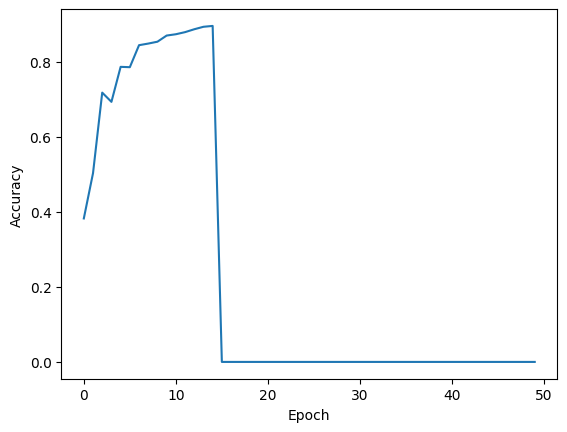

In [19]:
plt.plot(accuracy_list)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

# mean over multiple trainings

In [14]:
EPOCHS = 50
num_iter = 10
percent_inj2 = []
redundandency = 2

In [15]:
for i in tqdm.trange(num_iter):

    # size of the layers
    l1 = 784*redundandency
    l2 = 128

        
    model     = Model(X_train.shape[1],l1)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
    loss_fn   = nn.CrossEntropyLoss()

    weights = []
    weights_norm = []
    norms = []
    biases = np.zeros([EPOCHS + 1,l1])
    percent_inj_list = []

    w1 = model.layer1.weight
    b1 = model.layer1.bias
    m1 = w1.shape[0]
    n1 = w1.shape[1]
    norm = w1.pow(2).sum(keepdim=True,dim=1).sqrt()
    w1_norm = torch.div(w1,norm)
    w1_norm[w1_norm == np.inf] = 0

        
    weights.append(w1.detach().numpy())
    weights_norm.append(w1_norm.detach().numpy())
    norms.append(norm.detach().numpy())
    biases[0,:] = b1.detach().numpy()

    #epoch counter
    k = 1


    loss_list     = np.zeros((EPOCHS,))
    accuracy_list = np.zeros((EPOCHS,))

    for epoch in tqdm.trange(EPOCHS):
        y_pred = model(X_train)
        loss = loss_fn(y_pred, y_train)
        loss_list[epoch] = loss.item()
        
        # Zero gradients
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        with torch.no_grad():
            y_pred = model(X_test)
            correct = (torch.argmax(y_pred, dim=1) == y_test).type(torch.FloatTensor)
            accuracy_list[epoch] = correct.mean()
            if epoch % 5 == 0:
                print(f"Epoch {epoch}: Loss {loss.item()}, Accuracy {correct.mean()}")
        
        
        
        w1 = model.layer1.weight
        b1 = model.layer1.bias

        if epoch % 5 == 0:
            print("check inj")
            # check injectivity 
            percent_inj = mcbe.check_injectivity_naive(w1.detach().numpy(),b1.detach().numpy(),points=X_test[:1000,:],iter=X_test[:1000,:].shape[0])
            percent_inj_list.append(percent_inj)
            print("percent_inj: ", percent_inj)

        norm = w1.pow(2).sum(keepdim=True,dim=1).sqrt()
        w1_norm = torch.div(w1,norm)
        w1_norm[w1_norm == np.inf] = 0
        
        weights.append(w1.detach().numpy())
        weights_norm.append(w1_norm.detach().numpy())
        norms.append(norm.detach().numpy())
        biases[k,:] = b1.detach().numpy()
        
        k = k+1

    percent_inj2.append(percent_inj_list)

    
        
    

    

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0: Loss 2.3017966747283936, Accuracy 0.3582000136375427
check inj


percent_inj:  0.249


Epoch 5: Loss 1.8191099166870117, Accuracy 0.6496000289916992
check inj


percent_inj:  0.274


Epoch 10: Loss 1.7719894647598267, Accuracy 0.6980999708175659
check inj


percent_inj:  0.337


Epoch 15: Loss 1.749098539352417, Accuracy 0.722000002861023
check inj


percent_inj:  0.367


Epoch 20: Loss 1.729794979095459, Accuracy 0.7373999953269958
check inj


percent_inj:  0.376


Epoch 25: Loss 1.7175939083099365, Accuracy 0.7462999820709229
check inj


percent_inj:  0.391


Epoch 30: Loss 1.7098040580749512, Accuracy 0.7512999773025513
check inj


percent_inj:  0.392


Epoch 35: Loss 1.7045915126800537, Accuracy 0.7542999982833862
check inj


percent_inj:  0.389


Epoch 40: Loss 1.7002506256103516, Accuracy 0.7581999897956848
check inj


percent_inj:  0.395


Epoch 45: Loss 1.6975040435791016, Accuracy 0.7591999769210815
check inj


percent_inj:  0.395


 10%|█         | 1/10 [06:00<54:08, 360.97s/it]

Epoch 0: Loss 2.3029625415802, Accuracy 0.3084000051021576
check inj


percent_inj:  0.223


Epoch 5: Loss 1.806640386581421, Accuracy 0.6510999798774719
check inj


percent_inj:  0.311


Epoch 10: Loss 1.755106806755066, Accuracy 0.7200000286102295
check inj


percent_inj:  0.312


Epoch 15: Loss 1.699124813079834, Accuracy 0.7750999927520752
check inj


percent_inj:  0.331


Epoch 20: Loss 1.6783608198165894, Accuracy 0.7864999771118164
check inj


percent_inj:  0.348


Epoch 25: Loss 1.6611515283584595, Accuracy 0.803600013256073
check inj


percent_inj:  0.36


Epoch 30: Loss 1.6471260786056519, Accuracy 0.817300021648407
check inj


percent_inj:  0.352


Epoch 35: Loss 1.6349126100540161, Accuracy 0.8271999955177307
check inj


percent_inj:  0.359


Epoch 40: Loss 1.6239838600158691, Accuracy 0.8378999829292297
check inj


percent_inj:  0.36


Epoch 45: Loss 1.616256594657898, Accuracy 0.8443999886512756
check inj


percent_inj:  0.368


 20%|██        | 2/10 [11:33<45:54, 344.27s/it]

Epoch 0: Loss 2.3018147945404053, Accuracy 0.3653999865055084
check inj


percent_inj:  0.214


Epoch 5: Loss 1.867862343788147, Accuracy 0.7095999717712402
check inj


percent_inj:  0.24


Epoch 10: Loss 1.7034608125686646, Accuracy 0.7631000280380249
check inj


percent_inj:  0.246


Epoch 15: Loss 1.6617296934127808, Accuracy 0.8015000224113464
check inj


percent_inj:  0.282


Epoch 20: Loss 1.6442055702209473, Accuracy 0.8145999908447266
check inj


percent_inj:  0.291


Epoch 25: Loss 1.631961464881897, Accuracy 0.8240000009536743
check inj


percent_inj:  0.301


Epoch 30: Loss 1.6228049993515015, Accuracy 0.8342000246047974
check inj


percent_inj:  0.308


Epoch 35: Loss 1.6152455806732178, Accuracy 0.8398000001907349
check inj


percent_inj:  0.31


Epoch 40: Loss 1.6093933582305908, Accuracy 0.8439000248908997
check inj


percent_inj:  0.319


Epoch 45: Loss 1.6044255495071411, Accuracy 0.8456000089645386
check inj


percent_inj:  0.329


 30%|███       | 3/10 [17:21<40:20, 345.80s/it]

Epoch 0: Loss 2.302651882171631, Accuracy 0.2842999994754791
check inj


percent_inj:  0.243


Epoch 5: Loss 1.7787073850631714, Accuracy 0.7103000283241272
check inj


percent_inj:  0.244


Epoch 10: Loss 1.6776124238967896, Accuracy 0.7919999957084656
check inj


percent_inj:  0.251


Epoch 15: Loss 1.642956256866455, Accuracy 0.8199999928474426
check inj


percent_inj:  0.272


Epoch 20: Loss 1.6311947107315063, Accuracy 0.8274999856948853
check inj


percent_inj:  0.284


Epoch 25: Loss 1.6201746463775635, Accuracy 0.8346999883651733
check inj


percent_inj:  0.293


Epoch 30: Loss 1.6128640174865723, Accuracy 0.839900016784668
check inj


percent_inj:  0.295


Epoch 35: Loss 1.608125925064087, Accuracy 0.8442999720573425
check inj


percent_inj:  0.302


Epoch 40: Loss 1.604042887687683, Accuracy 0.8464999794960022
check inj


percent_inj:  0.306


Epoch 45: Loss 1.6009526252746582, Accuracy 0.8482999801635742
check inj


percent_inj:  0.309


 40%|████      | 4/10 [23:45<36:05, 360.98s/it]

Epoch 0: Loss 2.3026678562164307, Accuracy 0.34880000352859497
check inj


percent_inj:  0.235


Epoch 5: Loss 1.8011647462844849, Accuracy 0.6736000180244446
check inj


percent_inj:  0.273


Epoch 10: Loss 1.7595716714859009, Accuracy 0.7099000215530396
check inj


percent_inj:  0.309


Epoch 15: Loss 1.7298907041549683, Accuracy 0.7301999926567078
check inj


percent_inj:  0.309


Epoch 20: Loss 1.717276930809021, Accuracy 0.742900013923645
check inj


percent_inj:  0.3


Epoch 25: Loss 1.7084753513336182, Accuracy 0.7495999932289124
check inj


percent_inj:  0.301


Epoch 30: Loss 1.7020200490951538, Accuracy 0.7523999810218811
check inj


percent_inj:  0.306


Epoch 35: Loss 1.696603775024414, Accuracy 0.7551000118255615
check inj


percent_inj:  0.309


Epoch 40: Loss 1.693367838859558, Accuracy 0.7577000260353088
check inj


percent_inj:  0.312


Epoch 45: Loss 1.6912246942520142, Accuracy 0.7597000002861023
check inj


percent_inj:  0.319


 50%|█████     | 5/10 [30:09<30:46, 369.28s/it]

Epoch 0: Loss 2.3021814823150635, Accuracy 0.3183000087738037
check inj


percent_inj:  0.37


Epoch 5: Loss 1.7756506204605103, Accuracy 0.7501000165939331
check inj


percent_inj:  0.293


Epoch 10: Loss 1.6847267150878906, Accuracy 0.7878000140190125
check inj


percent_inj:  0.286


Epoch 15: Loss 1.6544636487960815, Accuracy 0.8105999827384949
check inj


percent_inj:  0.285


Epoch 20: Loss 1.6418479681015015, Accuracy 0.8230000138282776
check inj


percent_inj:  0.297


Epoch 25: Loss 1.630379319190979, Accuracy 0.8299000263214111
check inj


percent_inj:  0.312


Epoch 30: Loss 1.6226969957351685, Accuracy 0.8360999822616577
check inj


percent_inj:  0.318


Epoch 35: Loss 1.616700291633606, Accuracy 0.8389000296592712
check inj


percent_inj:  0.324


Epoch 40: Loss 1.6126351356506348, Accuracy 0.8429999947547913
check inj


percent_inj:  0.331


Epoch 45: Loss 1.6095373630523682, Accuracy 0.8475000262260437
check inj


percent_inj:  0.328


 60%|██████    | 6/10 [37:13<25:52, 388.06s/it]

Epoch 0: Loss 2.3032171726226807, Accuracy 0.4925000071525574
check inj


percent_inj:  0.346


Epoch 5: Loss 1.883074164390564, Accuracy 0.5735999941825867
check inj


percent_inj:  0.309


Epoch 10: Loss 1.8717713356018066, Accuracy 0.5986999869346619
check inj


percent_inj:  0.357


Epoch 15: Loss 1.8270000219345093, Accuracy 0.6499999761581421
check inj


percent_inj:  0.38


Epoch 20: Loss 1.7659085988998413, Accuracy 0.7021999955177307
check inj


percent_inj:  0.378


Epoch 25: Loss 1.744028091430664, Accuracy 0.7174000144004822
check inj


percent_inj:  0.359


Epoch 30: Loss 1.7300310134887695, Accuracy 0.73089998960495
check inj


percent_inj:  0.35


Epoch 35: Loss 1.722503423690796, Accuracy 0.7357000112533569
check inj


percent_inj:  0.351


Epoch 40: Loss 1.7160342931747437, Accuracy 0.7400000095367432
check inj


percent_inj:  0.358


Epoch 45: Loss 1.7104073762893677, Accuracy 0.7451000213623047
check inj


percent_inj:  0.363


 70%|███████   | 7/10 [45:01<20:42, 414.10s/it]

Epoch 0: Loss 2.3021748065948486, Accuracy 0.3797999918460846
check inj


percent_inj:  0.331


Epoch 5: Loss 1.8344382047653198, Accuracy 0.656000018119812
check inj


percent_inj:  0.27


Epoch 10: Loss 1.7676481008529663, Accuracy 0.7084000110626221
check inj


percent_inj:  0.289


Epoch 15: Loss 1.7398664951324463, Accuracy 0.7257999777793884
check inj


percent_inj:  0.292


Epoch 20: Loss 1.7266356945037842, Accuracy 0.7366999983787537
check inj


percent_inj:  0.293


Epoch 25: Loss 1.71724271774292, Accuracy 0.744700014591217
check inj


percent_inj:  0.296


Epoch 30: Loss 1.7113902568817139, Accuracy 0.7497000098228455
check inj


percent_inj:  0.304


Epoch 35: Loss 1.7070084810256958, Accuracy 0.7516999840736389
check inj


percent_inj:  0.307


Epoch 40: Loss 1.703377604484558, Accuracy 0.755299985408783
check inj


percent_inj:  0.309


Epoch 45: Loss 1.7003741264343262, Accuracy 0.7567999958992004
check inj


percent_inj:  0.315


 80%|████████  | 8/10 [51:46<13:42, 411.31s/it]

Epoch 0: Loss 2.30300235748291, Accuracy 0.41850000619888306
check inj


percent_inj:  0.313


Epoch 5: Loss 1.7698688507080078, Accuracy 0.7084000110626221
check inj


percent_inj:  0.265


Epoch 10: Loss 1.6845990419387817, Accuracy 0.7885000109672546
check inj


percent_inj:  0.276


Epoch 15: Loss 1.6579917669296265, Accuracy 0.8058000206947327
check inj


percent_inj:  0.282


Epoch 20: Loss 1.6389275789260864, Accuracy 0.8222000002861023
check inj


percent_inj:  0.293


Epoch 25: Loss 1.629797101020813, Accuracy 0.8281000256538391
check inj


percent_inj:  0.296


Epoch 30: Loss 1.620822787284851, Accuracy 0.8345000147819519
check inj


percent_inj:  0.302


Epoch 35: Loss 1.6148035526275635, Accuracy 0.8398000001907349
check inj


percent_inj:  0.304


Epoch 40: Loss 1.6094189882278442, Accuracy 0.8432999849319458
check inj


percent_inj:  0.308


Epoch 45: Loss 1.6052415370941162, Accuracy 0.8460000157356262
check inj


percent_inj:  0.307


 90%|█████████ | 9/10 [59:07<07:00, 420.46s/it]

Epoch 0: Loss 2.3028807640075684, Accuracy 0.32089999318122864
check inj


percent_inj:  0.263


Epoch 5: Loss 1.8426674604415894, Accuracy 0.6908000111579895
check inj


percent_inj:  0.333


Epoch 10: Loss 1.7600582838058472, Accuracy 0.7135999798774719
check inj


percent_inj:  0.37


Epoch 15: Loss 1.734941005706787, Accuracy 0.7440999746322632
check inj


percent_inj:  0.378


Epoch 20: Loss 1.6590890884399414, Accuracy 0.7972000241279602
check inj


percent_inj:  0.402


Epoch 25: Loss 1.6412230730056763, Accuracy 0.8263999819755554
check inj


percent_inj:  0.393


Epoch 30: Loss 1.6303821802139282, Accuracy 0.8312000036239624
check inj


percent_inj:  0.384


Epoch 35: Loss 1.6235628128051758, Accuracy 0.8360999822616577
check inj


percent_inj:  0.375


Epoch 40: Loss 1.6177434921264648, Accuracy 0.8410999774932861
check inj


percent_inj:  0.364


Epoch 45: Loss 1.613219141960144, Accuracy 0.8446000218391418
check inj


percent_inj:  0.366


100%|██████████| 10/10 [1:05:58<00:00, 395.89s/it]


In [16]:
percent_inj3 = []
redundandency = 3

In [17]:
for i in tqdm.trange(num_iter):

    # size of the layers
    l1 = 784*redundandency
    l2 = 128

        
    model     = Model(X_train.shape[1],l1)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
    loss_fn   = nn.CrossEntropyLoss()

    weights = []
    weights_norm = []
    norms = []
    biases = np.zeros([EPOCHS + 1,l1])
    percent_inj_list = []

    w1 = model.layer1.weight
    b1 = model.layer1.bias
    m1 = w1.shape[0]
    n1 = w1.shape[1]
    norm = w1.pow(2).sum(keepdim=True,dim=1).sqrt()
    w1_norm = torch.div(w1,norm)
    w1_norm[w1_norm == np.inf] = 0

        
    weights.append(w1.detach().numpy())
    weights_norm.append(w1_norm.detach().numpy())
    norms.append(norm.detach().numpy())
    biases[0,:] = b1.detach().numpy()

    #epoch counter
    k = 1


    loss_list     = np.zeros((EPOCHS,))
    accuracy_list = np.zeros((EPOCHS,))

    for epoch in range(EPOCHS):
        y_pred = model(X_train)
        loss = loss_fn(y_pred, y_train)
        loss_list[epoch] = loss.item()
        
        # Zero gradients
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        with torch.no_grad():
            y_pred = model(X_test)
            correct = (torch.argmax(y_pred, dim=1) == y_test).type(torch.FloatTensor)
            accuracy_list[epoch] = correct.mean()
            if epoch % 5 == 0:
                print(f"Epoch {epoch}: Loss {loss.item()}, Accuracy {correct.mean()}")
        
        
        
        w1 = model.layer1.weight
        b1 = model.layer1.bias

        if epoch % 5 == 0:
            print("check inj")
            # check injectivity 
            percent_inj = mcbe.check_injectivity_naive(w1.detach().numpy(),b1.detach().numpy(),points=X_test[:1000,:],iter=X_test[:1000,:].shape[0])
            percent_inj_list.append(percent_inj)
            print("percent_inj: ", percent_inj)

        norm = w1.pow(2).sum(keepdim=True,dim=1).sqrt()
        w1_norm = torch.div(w1,norm)
        w1_norm[w1_norm == np.inf] = 0
        
        weights.append(w1.detach().numpy())
        weights_norm.append(w1_norm.detach().numpy())
        norms.append(norm.detach().numpy())
        biases[k,:] = b1.detach().numpy()
        
        k = k+1

    percent_inj3.append(percent_inj_list)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0: Loss 2.302694320678711, Accuracy 0.26089999079704285
check inj
percent_inj:  1.0
Epoch 5: Loss 1.8138740062713623, Accuracy 0.5655999779701233
check inj
percent_inj:  0.822
Epoch 10: Loss 1.7443777322769165, Accuracy 0.7382000088691711
check inj
percent_inj:  0.836
Epoch 15: Loss 1.6914780139923096, Accuracy 0.7792999744415283
check inj
percent_inj:  0.872
Epoch 20: Loss 1.6660932302474976, Accuracy 0.7932000160217285
check inj
percent_inj:  0.883
Epoch 25: Loss 1.6493080854415894, Accuracy 0.8100000023841858
check inj
percent_inj:  0.866
Epoch 30: Loss 1.6393073797225952, Accuracy 0.820900022983551
check inj
percent_inj:  0.86
Epoch 35: Loss 1.628646731376648, Accuracy 0.8278999924659729
check inj
percent_inj:  0.86
Epoch 40: Loss 1.620458960533142, Accuracy 0.8360000252723694
check inj
percent_inj:  0.846
Epoch 45: Loss 1.6142566204071045, Accuracy 0.840499997138977
check inj
percent_inj:  0.846


 10%|█         | 1/10 [08:16<1:14:32, 496.93s/it]

Epoch 0: Loss 2.3029069900512695, Accuracy 0.5401999950408936
check inj
percent_inj:  1.0
Epoch 5: Loss 1.826807975769043, Accuracy 0.6607000231742859
check inj
percent_inj:  0.981
Epoch 10: Loss 1.7554978132247925, Accuracy 0.7103999853134155
check inj
percent_inj:  0.959
Epoch 15: Loss 1.7385907173156738, Accuracy 0.7228999733924866
check inj
percent_inj:  0.956
Epoch 20: Loss 1.7251092195510864, Accuracy 0.7361000180244446
check inj
percent_inj:  0.952
Epoch 25: Loss 1.7186747789382935, Accuracy 0.7409999966621399
check inj
percent_inj:  0.955
Epoch 30: Loss 1.7129184007644653, Accuracy 0.7450000047683716
check inj
percent_inj:  0.954
Epoch 35: Loss 1.7081408500671387, Accuracy 0.7480999827384949
check inj
percent_inj:  0.949
Epoch 40: Loss 1.705213189125061, Accuracy 0.7491000294685364
check inj
percent_inj:  0.947
Epoch 45: Loss 1.702966570854187, Accuracy 0.7513999938964844
check inj
percent_inj:  0.95


 20%|██        | 2/10 [15:16<1:00:10, 451.30s/it]

Epoch 0: Loss 2.302063465118408, Accuracy 0.48179998993873596
check inj
percent_inj:  1.0
Epoch 5: Loss 1.8838022947311401, Accuracy 0.7085999846458435
check inj
percent_inj:  0.874
Epoch 10: Loss 1.71368408203125, Accuracy 0.769599974155426
check inj
percent_inj:  0.866
Epoch 15: Loss 1.6677956581115723, Accuracy 0.7986000180244446
check inj
percent_inj:  0.924
Epoch 20: Loss 1.6468636989593506, Accuracy 0.8134999871253967
check inj
percent_inj:  0.93
Epoch 25: Loss 1.6370978355407715, Accuracy 0.8238000273704529
check inj
percent_inj:  0.898
Epoch 30: Loss 1.6291686296463013, Accuracy 0.8306999802589417
check inj
percent_inj:  0.884
Epoch 35: Loss 1.6233717203140259, Accuracy 0.8357999920845032
check inj
percent_inj:  0.875
Epoch 40: Loss 1.6185705661773682, Accuracy 0.839900016784668
check inj
percent_inj:  0.887
Epoch 45: Loss 1.6142815351486206, Accuracy 0.8425999879837036
check inj
percent_inj:  0.883


 30%|███       | 3/10 [22:34<51:56, 445.24s/it]  

Epoch 0: Loss 2.3040127754211426, Accuracy 0.4009999930858612
check inj
percent_inj:  1.0
Epoch 5: Loss 1.795184850692749, Accuracy 0.7336000204086304
check inj
percent_inj:  0.991
Epoch 10: Loss 1.6715569496154785, Accuracy 0.802299976348877
check inj
percent_inj:  0.987
Epoch 15: Loss 1.6469424962997437, Accuracy 0.8192999958992004
check inj
percent_inj:  0.968
Epoch 20: Loss 1.6302194595336914, Accuracy 0.8313000202178955
check inj
percent_inj:  0.953
Epoch 25: Loss 1.6214488744735718, Accuracy 0.8402000069618225
check inj
percent_inj:  0.949
Epoch 30: Loss 1.6134849786758423, Accuracy 0.8468000292778015
check inj
percent_inj:  0.947
Epoch 35: Loss 1.6084716320037842, Accuracy 0.8497999906539917
check inj
percent_inj:  0.95
Epoch 40: Loss 1.6044468879699707, Accuracy 0.8547999858856201
check inj
percent_inj:  0.952
Epoch 45: Loss 1.6012251377105713, Accuracy 0.859000027179718
check inj
percent_inj:  0.952


 40%|████      | 4/10 [31:52<48:58, 489.82s/it]

Epoch 0: Loss 2.3035728931427, Accuracy 0.4072999954223633
check inj
percent_inj:  1.0
Epoch 5: Loss 1.8432903289794922, Accuracy 0.7203999757766724
check inj
percent_inj:  0.824
Epoch 10: Loss 1.7006677389144897, Accuracy 0.7802000045776367
check inj
percent_inj:  0.845
Epoch 15: Loss 1.665335774421692, Accuracy 0.8065999746322632
check inj
percent_inj:  0.89
Epoch 20: Loss 1.6463966369628906, Accuracy 0.8215000033378601
check inj
percent_inj:  0.957
Epoch 25: Loss 1.634429693222046, Accuracy 0.8307999968528748
check inj
percent_inj:  0.965
Epoch 30: Loss 1.6255470514297485, Accuracy 0.8399999737739563
check inj
percent_inj:  0.964
Epoch 35: Loss 1.6189497709274292, Accuracy 0.8431000113487244
check inj
percent_inj:  0.968
Epoch 40: Loss 1.6130151748657227, Accuracy 0.8482000231742859
check inj
percent_inj:  0.967
Epoch 45: Loss 1.607876181602478, Accuracy 0.8517000079154968
check inj
percent_inj:  0.969


 50%|█████     | 5/10 [40:20<41:21, 496.33s/it]

Epoch 0: Loss 2.30348539352417, Accuracy 0.28760001063346863
check inj
percent_inj:  1.0
Epoch 5: Loss 1.950397253036499, Accuracy 0.538100004196167
check inj
percent_inj:  0.873
Epoch 10: Loss 1.8573259115219116, Accuracy 0.6693000197410583
check inj
percent_inj:  0.858
Epoch 15: Loss 1.765676736831665, Accuracy 0.7091000080108643
check inj
percent_inj:  0.9
Epoch 20: Loss 1.7446633577346802, Accuracy 0.7232999801635742
check inj
percent_inj:  0.874
Epoch 25: Loss 1.7299400568008423, Accuracy 0.7371000051498413
check inj
percent_inj:  0.9
Epoch 30: Loss 1.7228467464447021, Accuracy 0.7419999837875366
check inj
percent_inj:  0.907
Epoch 35: Loss 1.7164570093154907, Accuracy 0.7455999851226807
check inj
percent_inj:  0.9
Epoch 40: Loss 1.7115821838378906, Accuracy 0.75
check inj
percent_inj:  0.896
Epoch 45: Loss 1.7079315185546875, Accuracy 0.7522000074386597
check inj
percent_inj:  0.892


 60%|██████    | 6/10 [47:11<31:09, 467.47s/it]

Epoch 0: Loss 2.3025450706481934, Accuracy 0.2282000035047531
check inj
percent_inj:  1.0
Epoch 5: Loss 1.8270236253738403, Accuracy 0.6492000222206116
check inj
percent_inj:  0.99
Epoch 10: Loss 1.7983075380325317, Accuracy 0.6647999882698059
check inj
percent_inj:  0.984
Epoch 15: Loss 1.7601655721664429, Accuracy 0.7028999924659729
check inj
percent_inj:  0.94
Epoch 20: Loss 1.7234002351760864, Accuracy 0.7394999861717224
check inj
percent_inj:  0.892
Epoch 25: Loss 1.709126353263855, Accuracy 0.7491999864578247
check inj
percent_inj:  0.887
Epoch 30: Loss 1.7025340795516968, Accuracy 0.7537000179290771
check inj
percent_inj:  0.912
Epoch 35: Loss 1.6963982582092285, Accuracy 0.7588000297546387
check inj
percent_inj:  0.883
Epoch 40: Loss 1.6927244663238525, Accuracy 0.7605999708175659
check inj
percent_inj:  0.875
Epoch 45: Loss 1.6898728609085083, Accuracy 0.762499988079071
check inj
percent_inj:  0.875


 70%|███████   | 7/10 [56:10<24:32, 490.91s/it]

Epoch 0: Loss 2.302220582962036, Accuracy 0.38339999318122864
check inj
percent_inj:  1.0
Epoch 5: Loss 1.8727655410766602, Accuracy 0.6007999777793884
check inj
percent_inj:  0.998
Epoch 10: Loss 1.830615758895874, Accuracy 0.6392999887466431
check inj
percent_inj:  0.985
Epoch 15: Loss 1.813265085220337, Accuracy 0.651199996471405
check inj
percent_inj:  0.961
Epoch 20: Loss 1.8397372961044312, Accuracy 0.6121000051498413
check inj
percent_inj:  0.936
Epoch 25: Loss 1.8257744312286377, Accuracy 0.6413000226020813
check inj
percent_inj:  0.93
Epoch 30: Loss 1.813635230064392, Accuracy 0.6523000001907349
check inj
percent_inj:  0.933
Epoch 35: Loss 1.8073309659957886, Accuracy 0.6563000082969666
check inj
percent_inj:  0.922
Epoch 40: Loss 1.803166151046753, Accuracy 0.6589000225067139
check inj
percent_inj:  0.935
Epoch 45: Loss 1.7997970581054688, Accuracy 0.6611999869346619
check inj
percent_inj:  0.951


 80%|████████  | 8/10 [1:04:33<16:29, 494.77s/it]

Epoch 0: Loss 2.301543712615967, Accuracy 0.4377000033855438
check inj
percent_inj:  1.0
Epoch 5: Loss 1.9910290241241455, Accuracy 0.491100013256073
check inj
percent_inj:  0.963
Epoch 10: Loss 1.9385472536087036, Accuracy 0.5292999744415283
check inj
percent_inj:  0.963
Epoch 15: Loss 1.927559494972229, Accuracy 0.5364999771118164
check inj
percent_inj:  0.97
Epoch 20: Loss 1.9196051359176636, Accuracy 0.5422999858856201
check inj
percent_inj:  0.967
Epoch 25: Loss 1.9148142337799072, Accuracy 0.5471000075340271
check inj
percent_inj:  0.964
Epoch 30: Loss 1.910589575767517, Accuracy 0.5483999848365784
check inj
percent_inj:  0.968
Epoch 35: Loss 1.9072493314743042, Accuracy 0.5508000254631042
check inj
percent_inj:  0.971
Epoch 40: Loss 1.9045006036758423, Accuracy 0.5525000095367432
check inj
percent_inj:  0.972
Epoch 45: Loss 1.9021527767181396, Accuracy 0.5537999868392944
check inj
percent_inj:  0.971


 90%|█████████ | 9/10 [1:12:08<08:02, 482.05s/it]

Epoch 0: Loss 2.302914619445801, Accuracy 0.42879998683929443
check inj
percent_inj:  1.0
Epoch 5: Loss 1.8371806144714355, Accuracy 0.6563000082969666
check inj
percent_inj:  0.925
Epoch 10: Loss 1.7807643413543701, Accuracy 0.6973000168800354
check inj
percent_inj:  0.995
Epoch 15: Loss 1.7372113466262817, Accuracy 0.733299970626831
check inj
percent_inj:  0.995
Epoch 20: Loss 1.7193509340286255, Accuracy 0.7440999746322632
check inj
percent_inj:  0.993
Epoch 25: Loss 1.7117791175842285, Accuracy 0.7530999779701233
check inj
percent_inj:  0.991
Epoch 30: Loss 1.7050743103027344, Accuracy 0.7574999928474426
check inj
percent_inj:  0.99
Epoch 35: Loss 1.7012468576431274, Accuracy 0.7598999738693237
check inj
percent_inj:  0.99
Epoch 40: Loss 1.6970583200454712, Accuracy 0.7613999843597412
check inj
percent_inj:  0.99
Epoch 45: Loss 1.6942169666290283, Accuracy 0.7627999782562256
check inj
percent_inj:  0.99


100%|██████████| 10/10 [1:20:51<00:00, 485.19s/it]


In [18]:
percent_inj9 = []
redundandency = 9

In [19]:
for i in tqdm.trange(num_iter):

    # size of the layers
    l1 = 784*redundandency
    l2 = 128

        
    model     = Model(X_train.shape[1],l1)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
    loss_fn   = nn.CrossEntropyLoss()

    weights = []
    weights_norm = []
    norms = []
    biases = np.zeros([EPOCHS + 1,l1])
    percent_inj_list = []

    w1 = model.layer1.weight
    b1 = model.layer1.bias
    m1 = w1.shape[0]
    n1 = w1.shape[1]
    norm = w1.pow(2).sum(keepdim=True,dim=1).sqrt()
    w1_norm = torch.div(w1,norm)
    w1_norm[w1_norm == np.inf] = 0

        
    weights.append(w1.detach().numpy())
    weights_norm.append(w1_norm.detach().numpy())
    norms.append(norm.detach().numpy())
    biases[0,:] = b1.detach().numpy()

    #epoch counter
    k = 1


    loss_list     = np.zeros((EPOCHS,))
    accuracy_list = np.zeros((EPOCHS,))

    for epoch in range(EPOCHS):
        y_pred = model(X_train)
        loss = loss_fn(y_pred, y_train)
        loss_list[epoch] = loss.item()
        
        # Zero gradients
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        with torch.no_grad():
            y_pred = model(X_test)
            correct = (torch.argmax(y_pred, dim=1) == y_test).type(torch.FloatTensor)
            accuracy_list[epoch] = correct.mean()
            if epoch % 5 == 0:
                print(f"Epoch {epoch}: Loss {loss.item()}, Accuracy {correct.mean()}")
        
        
        
        w1 = model.layer1.weight
        b1 = model.layer1.bias

        if epoch % 5 == 0:
            print("check inj")
            # check injectivity 
            percent_inj = mcbe.check_injectivity_naive(w1.detach().numpy(),b1.detach().numpy(),points=X_test[:1000,:],iter=X_test[:1000,:].shape[0])
            percent_inj_list.append(percent_inj)
            print("percent_inj: ", percent_inj)

        norm = w1.pow(2).sum(keepdim=True,dim=1).sqrt()
        w1_norm = torch.div(w1,norm)
        w1_norm[w1_norm == np.inf] = 0
        
        weights.append(w1.detach().numpy())
        weights_norm.append(w1_norm.detach().numpy())
        norms.append(norm.detach().numpy())
        biases[k,:] = b1.detach().numpy()
        
        k = k+1

    percent_inj9.append(percent_inj_list)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0: Loss 2.3014729022979736, Accuracy 0.164900004863739
check inj
percent_inj:  1.0
Epoch 5: Loss 2.0873639583587646, Accuracy 0.3718000054359436
check inj
percent_inj:  1.0


In [ ]:
plt.rcParams.update({'font.family':'Times New Roman', 'font.size': 22})

In [ ]:
mean_inj2 = np.mean(percent_inj2,axis=0)
std_inj2 = np.std(percent_inj2,axis=0)
mean_inj3 = np.mean(percent_inj3,axis=0)
std_inj3 = np.std(percent_inj3,axis=0)
mean_inj9 = np.mean(percent_inj9,axis=0)
std_inj9 = np.std(percent_inj9,axis=0)
plt.plot(mean_inj2,label='Redundancy 2',color="blue",linestyle="--")
plt.fill_between(range(EPOCHS),mean_inj2-std_inj2,mean_inj2+std_inj2,alpha=0.2,color = "blue")
plt.plot(mean_inj3,label='Redundancy 3',color="red",linestyle=":")
plt.fill_between(range(EPOCHS),mean_inj3-std_inj3,mean_inj3+std_inj3,alpha=0.2,color="red")
plt.plot(mean_inj9,label='Redundancy 9',color = "lime")
plt.fill_between(range(EPOCHS),mean_inj9-std_inj9,mean_inj9+std_inj9,alpha=0.2)
plt.xlabel('Epoch')
plt.ylabel('Percent injectivity test set')
plt.ylim([0,1.1])
plt.legend()
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.grid(linestyle='--', alpha=0.5)

In [ ]:
#safe data
np.save('mean_inj2_mnist.npy',mean_inj2)
np.save('std_inj2_mnist.npy',std_inj2)
np.save('mean_inj3_mnist.npy',mean_inj3)
np.save('std_inj3_mnist.npy',std_inj3)
np.save('mean_inj9_mnist.npy',mean_inj9)
np.save('std_inj9_mnist.npy',std_inj9)